In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## Import

In [77]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

lowest_scored_thirty = lowest_scored_thirty = ['X344', 'X20','X117','X109','X378','X45','X362','X161','X164','X61',
 'X65','X380','X154', 'X300','X77', 'X114', 'X85', 'X321', 'X195','X209', 'X206', 'X283', 'X343', 'X340', 'X376',
 'X36', 'X375', 'X264', 'X250', 'X329',
 'X3', 'X0', 'X314', 'X350', 'X315', 'X180', 'X27', 'X261', 
 'X220', 'X321', 'X355', 'X29', 'X136',
# below are columns who only contains zeroes                                    
'X11', 'X93', 'X107', 'X233', 'X235', 'X268', 
'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


train.drop(lowest_scored_thirty, axis=1)
test.drop(lowest_scored_thirty, axis=1)

train.head(2)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0


In [78]:
# process columns
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
        
# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

train.head(2)

Shape train: (4209, 378)
Shape test: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0


## Preprocess

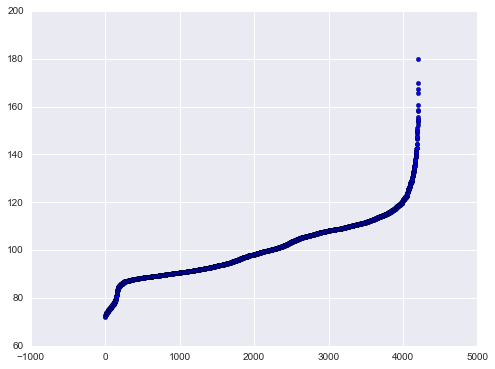

In [79]:
# modify the outlier of y who's larger than 180 to 180
y_train = train["y"]
y_mean = np.mean(y_train)

y_ultimate = 180
y_train.ix[y_train > y_ultimate] = y_ultimate

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(y_train))
plt.show()

## Add decomposed components: PCA/ICA etc.

In [80]:
from sklearn.decomposition import PCA, FastICA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]

train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,pca_6,ica_6,pca_7,ica_7,pca_8,ica_8,pca_9,ica_9,pca_10,ica_10
0,0,130.81,37,23,20,0,3,27,9,14,...,21.254898,0.014395,-2.752363,-0.033401,4.105945,0.012022,-1.642611,-0.007627,-0.498590,0.003856
1,6,88.53,37,21,22,4,3,31,11,14,...,25.188492,0.006875,-4.507475,0.000700,-0.477142,0.003406,-0.930733,-0.007189,-0.626754,0.009043
2,7,76.26,24,24,38,2,3,30,9,23,...,23.057021,0.026379,-2.232810,-0.011741,1.171961,-0.001692,-1.701210,0.006152,-0.436644,0.007842
3,9,80.62,24,21,38,5,3,30,11,4,...,25.484677,0.027262,-4.362057,0.014626,-1.888300,0.000525,-2.218976,0.007415,0.212041,0.007190
4,13,78.02,24,23,38,5,3,14,3,13,...,8.548080,0.032198,3.716605,0.015824,-1.741610,0.004502,-2.174680,0.007245,1.282105,-0.012682


## Prepare regressor

In [90]:
import xgboost as xgb

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
x_train = train.drop('y', axis=1)#.drop('ID', axis=1)
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=800,
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)



[0]	train-rmse:12.4434	test-rmse:12.444
[50]	train-rmse:10.8624	test-rmse:10.9284
[100]	train-rmse:9.76173	test-rmse:9.89484
[150]	train-rmse:9.01241	test-rmse:9.21617
[200]	train-rmse:8.50851	test-rmse:8.78074
[250]	train-rmse:8.17262	test-rmse:8.50681
[300]	train-rmse:7.94675	test-rmse:8.33516
[350]	train-rmse:7.78996	test-rmse:8.23096
[400]	train-rmse:7.66275	test-rmse:8.16883
[450]	train-rmse:7.55887	test-rmse:8.13049
[500]	train-rmse:7.47351	test-rmse:8.10788
[550]	train-rmse:7.40126	test-rmse:8.09577
[600]	train-rmse:7.33994	test-rmse:8.08831
[650]	train-rmse:7.28223	test-rmse:8.08406
[700]	train-rmse:7.22534	test-rmse:8.0815
[750]	train-rmse:7.16918	test-rmse:8.08198
703


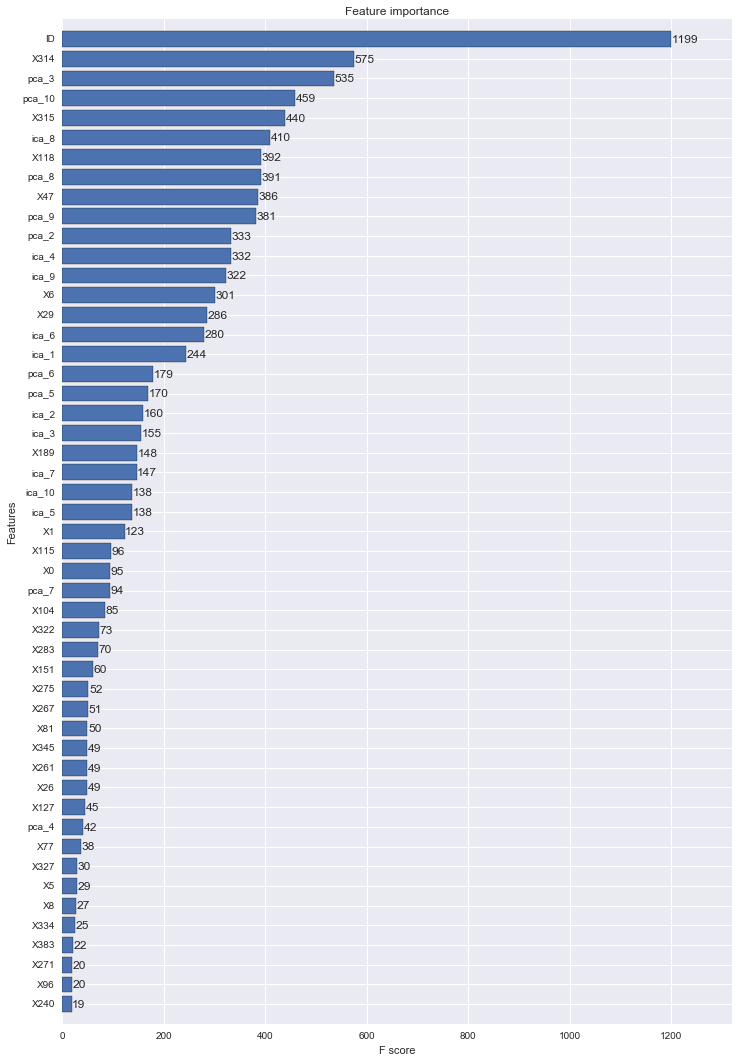

In [91]:
# plot the important features
fig, ax = plt.subplots(figsize=(12, 18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## check r2 score

In [92]:
# check r2-score (to get higher score - increase num_boost_round in previous cell)
from sklearn.metrics import r2_score

# now fixed, correct calculation
r2_score = r2_score(dtrain.get_label(), model.predict(dtrain))
print(r2_score)

0.647095234893


In [95]:
# make predictions and save results
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('./result/xgboost-depth{}-pca-r2={}.csv'.format(xgb_params['max_depth'], r2_score), index=False)
